<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynsep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/equinor/neqsim-python.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 23.7 MB/s eta 0:00:00


# Making a simple process with a separator with level controll on liquid outlet valve

0.199951171875
0.20068359375
time for 1 step:  0.27 s
time for 1000.00 steps: 40.94 s. Average: 0.04


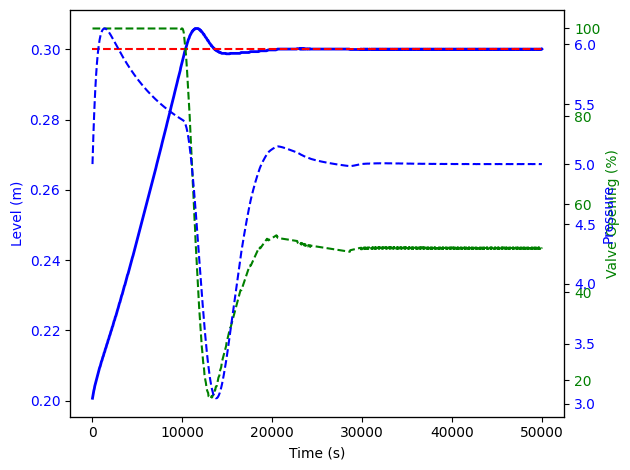

In [3]:
# imports
from neqsim import jneqsim as ns

from neqsim.thermo import fluid, TPflash,printFrame
import matplotlib.pyplot as plt
import time

# generic simulation variables
timeStep = 50 # time step in seconds
totalTime = 50000 # total simulation time in seconds

# some process variables
sepLength = 4.0
sepDiameter = 1.0
sepLiqLevel = 0.2
levelSP = 0.3
inletValveOpening = 50.0
inletValvePressure = 5.0
gasValveOpening = 50.0
gasValvePressure = 2.0
liquidValveOpening = 50.0
liquidValvePressure = 2.0

pWell = 18.0 # barg
tWell = 40.0 # C
flowRate = 150.0 # kg/hr
hDuty = 250000 # kW
pSep = 14.0 # barg
pGasOut = 2.0 # barg
pLiqOut = 2.0 # barg

# setup inlet stream composition and EOS
wellfluid = fluid("pr")
wellfluid.addComponent("CO2", 1.5870)
wellfluid.addComponent("methane", 52.51)
wellfluid.addComponent("ethane", 6.24)
wellfluid.addComponent("propane", 4.23)
wellfluid.addComponent("i-butane", 0.855)
wellfluid.addComponent("n-butane", 2.213)
wellfluid.addComponent("i-pentane", 1.124)
wellfluid.addComponent("n-pentane", 1.271)
wellfluid.addComponent("n-hexane", 2.289)
wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.9575)
wellfluid.setPressure(10)
wellfluid.setTemperature(300)
wellfluid.setMixingRule("classic")

# constrct the process

# well stream
wellStream = ns.process.equipment.stream.Stream("well stream",wellfluid)
wellStream.setFlowRate(flowRate,"kg/hr")

# Inlet valve
lcv00 = ns.process.equipment.valve.ThrottlingValve("LCV-00", wellStream) # Inlet control valve
lcv00.setPercentValveOpening(inletValveOpening) # initial guess of valve opening
lcv00.setOutletPressure(inletValvePressure)
lcv00.setCalculateSteadyState(False)
lcv00.setMinimumValveOpening(0.01)

# 1st stage separator
v001 = ns.process.equipment.separator.Separator("V-001", lcv00.getOutletStream()) # 1st stage separator
v001.setCalculateSteadyState(False)
v001.setSeparatorLength(sepLength) # meters
v001.setInternalDiameter(sepDiameter) # meters
v001.setLiquidLevel(sepLiqLevel) # initial guess of liquid level in separator (0-1)

lcv001 = ns.process.equipment.valve.ThrottlingValve("LCV-001", v001.getLiquidOutStream()) # Oil outlet control valve
lcv001.setPercentValveOpening(liquidValveOpening) # initial guess of valve opening
lcv001.setOutletPressure(liquidValvePressure)
lcv001.setCalculateSteadyState(False)

pcv001 = ns.process.equipment.valve.ThrottlingValve("PCV-001", v001.getGasOutStream()) # Gas outlet control valve
pcv001.setPercentValveOpening(gasValveOpening) # initial guess of valve opening
pcv001.setOutletPressure(gasValvePressure)
pcv001.setCalculateSteadyState(False)

# level transmitter and controller for vessel 001

lt01 = ns.process.measurementdevice.LevelTransmitter(v001)
lt01.setMaximumValue(0.99)
lt01.setMinimumValue(0.01)

lc01 = ns.process.controllerdevice.ControllerDeviceBaseClass()
lc01.setTransmitter(lt01)
lc01.setReverseActing(True)
lc01.setControllerSetPoint(levelSP)
lc01.setControllerParameters(25.80, 400.1, 0.0) # Kp, Ti, Td

pt01 = ns.process.measurementdevice.PressureTransmitter(v001.getGasOutStream())
pt01.setMaximumValue(10.0)
pt01.setMinimumValue(0.01)

pc01 = ns.process.controllerdevice.ControllerDeviceBaseClass()
pc01.setTransmitter(pt01)
pc01.setReverseActing(False)
pc01.setControllerSetPoint(inletValvePressure)
pc01.setControllerParameters(1.0, 2000.0, 0.0) # Kp, Ti, Td

oilProcess = ns.process.processmodel.ProcessSystem("oil process")
oilProcess.add(wellStream)
oilProcess.add(lcv00)
oilProcess.add(v001)
oilProcess.add(lcv001)
oilProcess.add(pcv001)
oilProcess.add(lt01)
oilProcess.add(pt01)
lcv00.setController(lc01)
pcv001.setController(pc01)

oilProcess.run()
oilProcess.storeInitialState()
print(lt01.getMeasuredValue())

# for graphical output
toime = []
valveOpening = []
pressure = []
separatorLevel = []
controllerAction = []
setpoint = []

oilProcess.setTimeStep(timeStep) # time step in seconds
start = time.time()
oilProcess.runTransient()

print(oilProcess.getUnit("V-001").getLiquidLevel())
end = time.time()
print(f"time for 1 step:  {(end - start):.2f} s")

start = time.time()

for i in range (int(totalTime/timeStep)):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

end = time.time()
print(f"time for {totalTime/timeStep:.2f} steps: {(end - start):.2f} s. Average: {(end - start)/(totalTime/timeStep):.2f}")

fig, ax1 = plt.subplots()

# Plot separator level on left y-axis
ax1.plot(toime, separatorLevel, 'b-', label="Level", linewidth=2)
ax1.plot(toime, setpoint, 'r--', label="Level")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Level (m)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for valve opening
ax2 = ax1.twinx()
ax2.plot(toime, valveOpening, 'g--', label="Valve Opening")
ax2.set_ylabel('Valve Opening (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for valve opening
ax3 = ax1.twinx()
ax3.plot(toime, pressure, 'b--', label="Pressure")
ax3.set_ylabel('Pressure', color='b')
ax3.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()

# Auto tune the level controller
Running a step response tuning

In [4]:
lc01.resetEventLog()
pc01.resetEventLog()

#step response
lc01.setControllerSetPoint(levelSP*1.1)

for i in range(100):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

#step response
lc01.setControllerSetPoint(levelSP*0.9)

for i in range(100):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

#uncomment to apply tuning
tuned = lc01.autoTuneFromEventLog(False)
tuner2 = pc01.autoTuneFromEventLog(False)

#print('tuned ', tuned)
print('Controller parameters')
kp = lc01.getKp()
ti = lc01.getTi()
td = lc01.getTd()
print('Kp ', lc01.getKp())
print('Ti ', lc01.getTi())
print('Td ', lc01.getTd())

#print('tuned ', tuned)
print('Controller parameters')
kp2 = pc01.getKp()
ti2 = pc01.getTi()
td2 = pc01.getTd()
print('Kp ', kp2)
print('Ti ', ti2)
print('Td ', td2)

Controller parameters
Kp  25.8
Ti  100.0
Td  0.0
Controller parameters
Kp  3.6644840409040467
Ti  9800.0
Td  0.0


# Run with tuned controller

increasing level set point.....

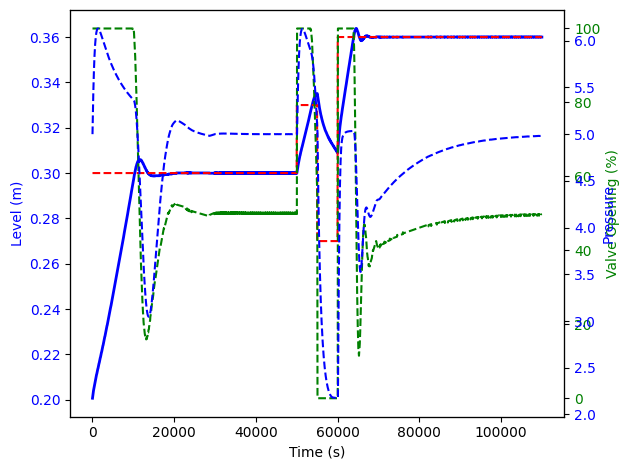

In [5]:
lc01.setControllerSetPoint(levelSP*1.2)

for i in range (int(totalTime/timeStep)):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

fig, ax1 = plt.subplots()

# Plot separator level on left y-axis
ax1.plot(toime, separatorLevel, 'b-', label="Level", linewidth=2)
ax1.plot(toime, setpoint, 'r--', label="Level")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Level (m)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for valve opening
ax2 = ax1.twinx()
ax2.plot(toime, valveOpening, 'g--', label="Valve Opening")
ax2.set_ylabel('Valve Opening (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for valve opening
ax3 = ax1.twinx()
ax3.plot(toime, pressure, 'b--', label="Pressure")
ax3.set_ylabel('Pressure', color='b')
ax3.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()

decreasing level set point.....

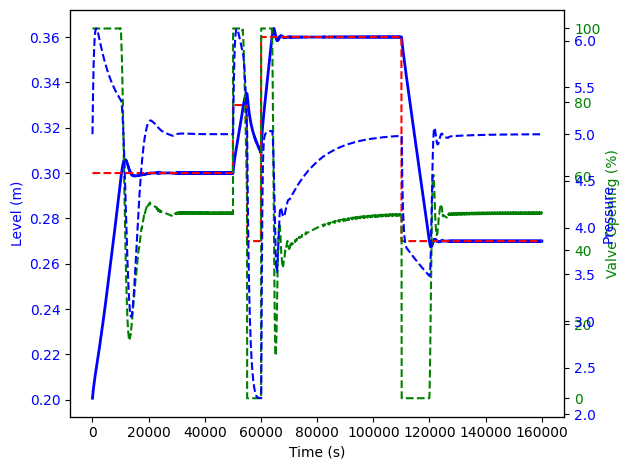

In [6]:
lc01.setControllerSetPoint(levelSP*0.9)

for i in range (int(totalTime/timeStep)):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

fig, ax1 = plt.subplots()

# Plot separator level on left y-axis
ax1.plot(toime, separatorLevel, 'b-', label="Level", linewidth=2)
ax1.plot(toime, setpoint, 'r--', label="Level")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Level (m)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for valve opening
ax2 = ax1.twinx()
ax2.plot(toime, valveOpening, 'g--', label="Valve Opening")
ax2.set_ylabel('Valve Opening (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for valve opening
ax3 = ax1.twinx()
ax3.plot(toime, pressure, 'b--', label="Pressure")
ax3.set_ylabel('Pressure', color='b')
ax3.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()

# Reducing the flow rate by throttling at the inlet valve

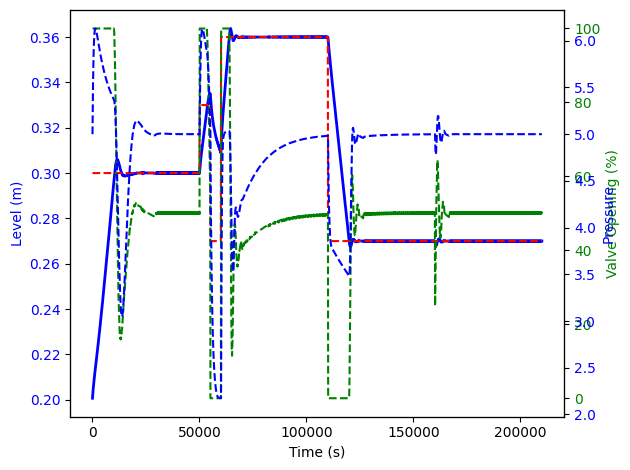

In [7]:
lcv00.setPercentValveOpening(inletValveOpening*0.5)

for i in range (int(totalTime/timeStep)):
    toime.append(oilProcess.getTime())
    valveOpening.append(lcv00.getPercentValveOpening())
    separatorLevel.append(oilProcess.getUnit("V-001").getLiquidLevel())
    controllerAction.append(lc01.getResponse())
    setpoint.append(lc01.getControllerSetPoint())
    pressure.append(lcv00.getOutletPressure())
    oilProcess.runTransient()

fig, ax1 = plt.subplots()

# Plot separator level on left y-axis
ax1.plot(toime, separatorLevel, 'b-', label="Level", linewidth=2)
ax1.plot(toime, setpoint, 'r--', label="Level")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Level (m)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for valve opening
ax2 = ax1.twinx()
ax2.plot(toime, valveOpening, 'g--', label="Valve Opening")
ax2.set_ylabel('Valve Opening (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a second y-axis for valve opening
ax3 = ax1.twinx()
ax3.plot(toime, pressure, 'b--', label="Pressure")
ax3.set_ylabel('Pressure', color='b')
ax3.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()